# MeLiChallenge

### MODELO BASADO EN EL ITEM MAS VISTO, USADO COMO KEY PARA 
### JOIN CON LA META DATA

Continuacion de la Notebook MeLiChallengeCustomDataSetPrep

El objetivo es averiguar que tan relacionado esta el item mas visto por el usuario con el item que finalizo comprando
Para tener una idea del bias que tendra el modelo de entrada en base a los datos provistos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

sns.set()

In [2]:
trainpath = 'C:\\Users\\desar\\OneDrive\\Escritorio\\data_science\\MeLi Challenge\\train_set.csv'
testpath = 'C:\\Users\\desar\\OneDrive\\Escritorio\\data_science\\MeLi Challenge\\test_set.csv'
itempath = 'C:\\Users\\desar\\OneDrive\\Escritorio\\data_science\\MeLi Challenge\\item_data.csv'

train = pd.read_csv(trainpath, parse_dates = ['time_buy'])
test = pd.read_csv(testpath, parse_dates = ['time_buy'])
items = pd.read_csv(itempath)

In [3]:
train.shape, test.shape

((413163, 9), (177070, 8))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413163 entries, 0 to 413162
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   item_bought     413163 non-null  int64  
 1   m_view_veces    386390 non-null  float64
 2   most_view       386390 non-null  float64
 3   most_view_2     315574 non-null  float64
 4   most_view_3     267727 non-null  float64
 5   art_vistos      413163 non-null  int64  
 6   time_buy        413163 non-null  object 
 7   view_entries    413163 non-null  int64  
 8   search_entries  413163 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 28.4+ MB


In [5]:
train['time_buy'] = train['time_buy'].str.replace('.000000000', '')
test['time_buy'] = test['time_buy'].str.replace('.000000000', '')

In [6]:
items.head()

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,NaN,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800.0,1392.83,MLM151595,new
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,NaN,350.00,MLM7697,new
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,NaN,3200.00,MLM9761,used
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,NaN,1599.00,MLM1652,used


In [7]:
len(items['category_id'].unique()), len(items['domain_id'].unique()), len(items['product_id'].unique())

(11493, 7894, 87831)

In [8]:
items['product_id'].isna().value_counts() 
#puro NaNs el Product Id
#puede ser porque los productos estandarizados o reg lo tienen y el resto no! tenes que ver mas!!
#aparentemente no..

True     1805749
False     296528
Name: product_id, dtype: int64

In [9]:
#al title si lo rajamos

items.drop(['title', 'product_id'], axis = 1, inplace = True)
items.tail(2)

,item_id,domain_id,price,category_id,condition
2102275,237229,MLB-DISPOSABLE_BABY_DIAPERS,26.90,MLB40629,new
2102276,2010306,MLB-VEHICLE_ACCESSORIES,64.99,MLB117639,new


MERGING:

Debo unir los data sets de item y de user history para empezar ya con el EDA, feature eng y finalmente el modelling.
Lo ideal seria usar el Item Bought como key, pero como el test set no lo tiene no es posible.
Por este motivo no queda otra que usar el most viewed item como Key.

Para eso tengo que ver si los datos del df Items para el most viewed, son similares a los datos para el item 
Bought, si no lo fueran entonces voy a meter un Bias muy grande al modelo.

Analizo entonces un df que contenga los datos del df Items para item bought y para item most viewed.
Haciendo un EDA y test de hipotesis para probar la similitud de los datos y de su ditribucion.

In [10]:
#Creo el df KEYS TEST desde el train y el items set

keys_test = pd.DataFrame({'item': train['item_bought'], 'most_viewed': train['most_view']})
items.rename(columns = {'item_id': 'item'}, inplace = True)
keys_test = pd.merge(keys_test, items, on='item', how='left')
keys_test.dropna(inplace = True) #me saco los datos que no me den info..
keys_test.head()

,item,most_viewed,domain_id,price,category_id,condition
0,1748830,1615991.0,MLB-SMARTWATCHES,90.00,MLB135384,new
1,228737,228737.0,MLB-MILK_EXTRACTORS,169.00,MLB264021,new
2,1909110,248595.0,MLB-CELLPHONE_ACCESSORIES,300.00,MLB5092,new
3,1197370,505541.0,MLB-CARD_PAYMENT_TERMINALS,16.90,MLB277951,new
4,2049207,1313192.0,MLB-SMARTWATCHES,355.99,MLB135384,new


In [11]:
#Ahora sumo el los datos para most viewed

items.rename(columns = {'item': 'item_most_view'}, inplace = True)
keys_test.rename(columns = {'most_viewed': 'item_most_view'}, inplace = True)
keys_test = pd.merge(keys_test, items, on='item_most_view', how='left')
keys_test.head()

#_x son los datos del item bought
#_y son los datos del item most viewed 

,item,item_most_view,domain_id_x,price_x,category_id_x,condition_x,domain_id_y,price_y,category_id_y,condition_y
0,1748830,1615991.0,MLB-SMARTWATCHES,90.00,MLB135384,new,MLB-SMARTWATCHES,79.71,MLB135384,new
1,228737,228737.0,MLB-MILK_EXTRACTORS,169.00,MLB264021,new,MLB-MILK_EXTRACTORS,169.00,MLB264021,new
2,1909110,248595.0,MLB-CELLPHONE_ACCESSORIES,300.00,MLB5092,new,MLB-TOWEL_SETS,139.00,MLB186353,new
3,1197370,505541.0,MLB-CARD_PAYMENT_TERMINALS,16.90,MLB277951,new,MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,14.99,MLB1730,used
4,2049207,1313192.0,MLB-SMARTWATCHES,355.99,MLB135384,new,MLB-KIDS_TENTS,199.99,MLB278224,new


In [12]:
keys_test['price_x'] = keys_test['price_x'].astype(float)
keys_test['price_y'] = keys_test['price_y'].astype(float)

In [19]:
#Rajo los Nans

keys_test['price_y'].dropna(inplace = True)
keys_test['price_y'].isnull().value_counts()

False    386343
Name: price_y, dtype: int64

In [14]:
#Podemos hacer un test de hipotesis para probar que la media del precio de ambos es igual
#Pero antes vemos la media observada

def mean_std_dev(x,y):
    '''Devuelve info de media y varianzas'''
    x.sort_values()
    y.sort_values()
    print('x: ', np.mean(x), np.std(x))
    print('y: ', np.mean(y), np.std(y))
    print('Diferencia de means: ', np.mean(x) - np.mean(y))
    print('Diferencia de std: ', np.std(x) - np.std(y))
    print('Medianas: ', np.median(x), np.median(y))
    print('Quartiles x: ', np.percentile(x, [0.25, 0.5, 0.75, 0.9]))
    print('Quartiles y: ', np.percentile(y, [0.25, 0.5, 0.75, 0.9]))
    
mean_std_dev(keys_test['price_x'], keys_test['price_y'])

#Nada que ver las medias...

x:  3064.4111316047743 509508.99525978655
y:  26314.04384489184 7259692.241326009
Diferencia de means:  -23249.632713287065
Diferencia de std:  -6750183.246066222
Medianas:  139.95 164.0
Quartiles x:  [ 6.25    10.      11.79    12.85501]
Quartiles y:  [ 8.38985 10.9     12.99    14.18   ]


vemos si la distribucion de precios es similar.
es la unica var numerica que tengo asi que me sirve para ver graficamente la relacion

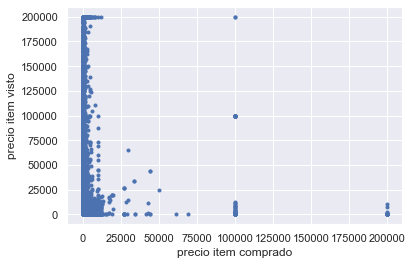

In [15]:
#Tengo que recortar outliers, sino el plot va a salir para muy fuera de escala sino

keys_test.loc[keys_test['price_x'] > 200000, 'price_x'] = 200000
keys_test.loc[keys_test['price_y'] > 200000, 'price_y'] = 200000

_= plt.plot(keys_test['price_x'], keys_test['price_y'], marker = '.', linestyle = 'none')
_= plt.xlabel('precio item comprado')
_= plt.ylabel('precio item visto')
plt.show()

A primera vista, pareciera que el item visto es mucho mas caro que el comprado, 
pero este plot no nos da una idea de la distribucion acumulada de los datos

Se ve el conjunto de puntos en el valor 200000 ya que ahi realice el recorte de datos

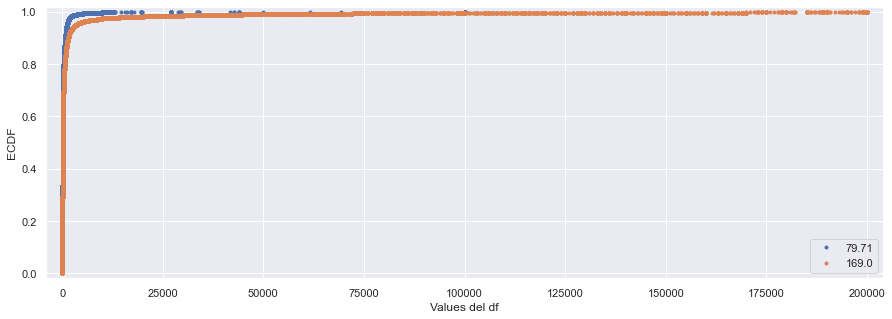

In [16]:
#Ploteamos curva de distribucion acumulada

plt.figure(figsize =(15,5))

def ecdf(series):
    '''Devuelve grafico de dist acumulada'''
    x = np.sort(series)
    y = np.arange(1, len(series)+1) / len(series)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.xlabel('Values del df')
    _ = plt.ylabel('ECDF')
    _ = plt.legend(series, loc = 'lower right')
    plt.margins(0.02)
    
ecdf(keys_test['price_x'])
ecdf(keys_test['price_y'])   

se observa una similitud en la distribucion..
es decir que el keys_test['price_x']scatter plot si bien era muy distinto, 
esa diferencia corresponde a muy pocos puntos 

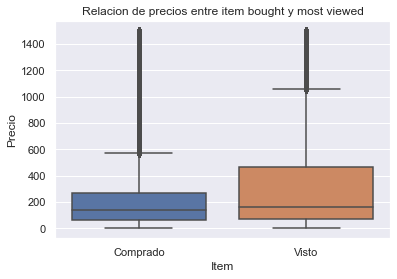

In [17]:
#Seria mejor ver todos esos datos en un box plot

price_x = pd.DataFrame({'Precio': keys_test['price_x']})
price_y = pd.DataFrame({'Precio': keys_test['price_y']})

price_x['Item'] = 'Comprado'
price_y['Item'] = 'Visto'

box_df = pd.concat([price_x, price_y], axis = 0)
box_df.Precio = box_df.Precio.astype('float')

box_df.loc[box_df['Precio'] > 1500, 'Precio'] = 1500 #recortando el Price a este nivel es visible el boxplot
#Puedo hacer esto ya que del ecdf veo que por arriba de 2000 son outliers..

box_df.sort_values(by = 'Precio', ascending = True, inplace = True)
box_df.dropna(inplace = True)

_= sns.boxplot(x = 'Item', y = 'Precio', data = box_df)
_= plt.title('Relacion de precios entre item bought y most viewed')

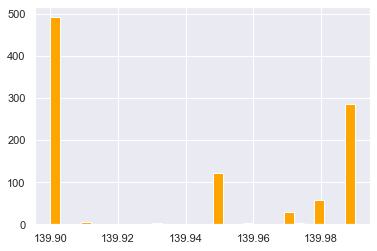

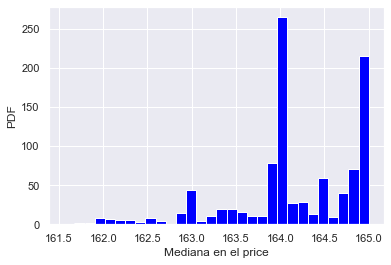

In [20]:
#analizamos la pdf de las medias de cada precio, a ver si si distribucion coincide en algun punto..

np.random.seed(42)

def bootstrap_replicate_1d(data, func):
    """Devuelve bootstrap replicates de un array unidimensional"""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

bs_replicates_x = np.empty(1000)
bs_replicates_y = np.empty(1000)

for i in range(1000):
    bs_replicates_x[i] = bootstrap_replicate_1d(keys_test['price_x'], np.median)
    bs_replicates_y[i] = bootstrap_replicate_1d(keys_test['price_y'], np.median)
    
_ = plt.hist(bs_replicates_x, bins=30, color = 'orange')

plt.show()

_ = plt.hist(bs_replicates_y, bins=30, color = 'blue')
_ = plt.xlabel('Mediana en el price')
_ = plt.ylabel('PDF')

plt.show()    

#Ni cerca ni por chance son iguales..

In [21]:
mean_std_dev(box_df['Precio'], box_df['Precio'])

x:  323.9992038388468 417.8949227448426
y:  323.9992038388468 417.8949227448426
Diferencia de means:  0.0
Diferencia de std:  0.0
Medianas:  149.9 149.9
Quartiles x:  [ 7.6766 10.     12.     13.5   ]
Quartiles y:  [ 7.6766 10.     12.     13.5   ]


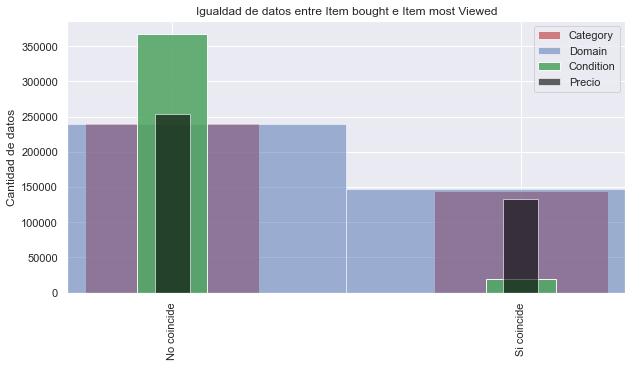

In [39]:
#Veamos si el resto de los datos coinciden al menos
#Al precio lo incluyo como que coincide si esta contenido en un rango mayor o igual a 150 dolares del precio_y

_= plt.figure(figsize=(10,5))

keys_test['igual_cat'] = 0 #inicializo la columna donde voy a guardar la info
keys_test.loc[keys_test['category_id_x'] == keys_test['category_id_y'], 'igual_cat'] = 1
_= keys_test['igual_cat'].value_counts().plot(kind = 'bar', width=0.5, color='r', alpha=0.7, label = 'Category')

keys_test['igual_dom'] = 0 
keys_test.loc[keys_test['domain_id_x'] == keys_test['domain_id_y'], 'igual_dom'] = 1
_= keys_test['igual_dom'].value_counts().plot(kind = 'bar', width= 1, color='b', alpha=0.5, label ='Domain')

keys_test['igual_cond'] = 0 
keys_test.loc[keys_test['condition_x'] == keys_test['condition_y'], 'igual_cond'] = 1
_= keys_test['igual_cond'].value_counts().plot(kind = 'bar', width= 0.2, color='g', alpha=0.9, label ='Condition')

keys_test['sim_precio'] = 0
keys_test.loc[(keys_test['price_x'] >= keys_test['price_y'] - 150) & 
              (keys_test['price_x'] <= keys_test['price_y'] + 150), 'sim_precio'] = 1
_= keys_test['sim_precio'].value_counts().plot(kind = 'bar', width= 0.1, color='black', alpha=0.6, label ='Precio')

_= plt.title('Igualdad de datos entre Item bought e Item most Viewed')
_= plt.legend()
_= plt.xticks([0, 1], ['No coincide', 'Si coincide'])
_= plt.ylabel('Cantidad de datos')

plt.show()

CONCLUSION

- 2/3 de los datos categoricos coinciden
- En el caso del dato binario (new/used) coincide en un 90%
- La distribucion del precio y su mediana es similar, aunque no su mean ni su std.
- 2/3 de los precios coinciden en un rango de 150 dolares... lo cual no es un rango muy aceptable..

Usar el most viewed item como key va a meter un bias al modelo,
Porque lo que el user vio no es lo mismo que lo que compro, en al menos un 30%

PASOS A SEGUIR

Salio una nota diciendo que el df esta muy biased por esta misma razon, que el historial de busqueda no es adecuado
por los mismos motivos vistos arriba.
Entonces el Bias este sera inherente a la mayoria de los analisis..
Ante esto, se avanza con el item most viewed como key entre ambos df y se elabora el modelo
En revisiones posteriores se sumaran otras keys como ultimo item visto, y otras columnas de interes para 
enriquecer el modelo.